# Data

| Feature Name               | Description                           |
|----------------------------|-------------------------------------|
| person_age                 | Age                                 |
| person_income              | Annual Income                       |
| person_home_ownership      | Home ownership                      |
| person_emp_length          | Employment length (in years)        |
| loan_intent                | Loan intent                        |
| loan_grade                 | Loan grade                        |
| loan_amnt                 | Loan amount                       |
| loan_int_rate              | Interest rate                     |
| loan_status                | Loan status (0 is non default, 1 is default) |
| loan_percent_income        | Percent income                    |
| cb_person_default_on_file  | Historical default                 |
| cb_preson_cred_hist_length | Credit history length              |


# Imports


In [56]:
# === Standard Libraries ===
import pickle
import joblib
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scikit-learn: Model Selection & Evaluation ===
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import  QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split
)
from sklearn.preprocessing import RobustScaler, StandardScaler

# === Machine Learning Libraries ===
import lightgbm as lgb
import xgboost as xgb

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.regularizers import l2

In [2]:
original_data=pd.read_csv('data_models\credit_risk_dataset.csv')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\david\AppData\Local\Temp\ipykernel_6588\1402595555.py:1: SyntaxWarning: invalid escape sequence '\c'
  original_data=pd.read_csv('data_models\credit_risk_dataset.csv')


In [4]:
print(original_data.shape)
32581*0.04

(32581, 12)


1303.24

# Transformations

## removing outliers

In [3]:
mask = (
    (original_data['person_age'] > 85) |
    (original_data['person_income'] > 1000000) |
    (original_data['person_emp_length'] > 50)
)
data=original_data[~mask]

In [ ]:
# Distribution Normalization
data['loan_amnt']=np.log(data['loan_amnt'])
data['person_income']=np.log(data['person_income'])
data['loan_percent_income']=np.log1p(data['loan_percent_income'])
data['person_age']=np.log(np.log(data['person_age']))
data['cb_person_cred_hist_length']=np.log(data['cb_person_cred_hist_length'])
data['person_emp_length']=np.log1p(data['person_emp_length'])

In [5]:
mask = (
    (data['person_income'] <  9.476) |
    (data['person_income'] > 12.361) )
data=data[~mask]

In [12]:
print("Original shape:", original_data.shape)
print("Filtered shape:", original_data.shape[0] - data.shape[0])

Original shape: (32581, 12)
Filtered shape: 584


In [14]:
# Calculate kurtosis and skewness for each variable in the dataset
kurtosis = data.kurtosis(numeric_only=True)
skewness = data.skew(numeric_only=True)

# Combine into a DataFrame for easy viewing
stats_df = pd.DataFrame({
    'Kurtosis': kurtosis,
    'Skewness': skewness
})

print(stats_df)

                            Kurtosis  Skewness
person_age                  0.801303  0.998882
person_income              -0.201056  0.005308
person_emp_length          -0.554115 -0.463644
loan_amnt                  -0.010007 -0.450535
loan_int_rate              -0.672869  0.209525
loan_status                -0.048103  1.397104
loan_percent_income         0.374645  0.805662
cb_person_cred_hist_length -0.827677  0.334368


Kurtosis higher than  |0.5| justifies robust scallers as there are moderate outliers

## one hot encoding

In [15]:
# Create one-hot encoded columns for person_home_ownership
home_ownership_encoded = pd.get_dummies(data['person_home_ownership'], prefix='home_ownership',  dtype=int)

# Create one-hot encoded columns for loan_intent  
loan_intent_encoded = pd.get_dummies(data['loan_intent'], prefix='loan_intent',  dtype=int)

# Concatenate the encoded columns with the original data
data_encoded = pd.concat([data, home_ownership_encoded, loan_intent_encoded], axis=1)

# Drop the original categorical columns
data_encoded = data_encoded.drop(['person_home_ownership','home_ownership_OTHER', 'loan_intent', 'loan_intent_HOMEIMPROVEMENT'], axis=1)

data = data_encoded


## ordinal and binary transformation

In [16]:
# Binary transformation for cb_person_default_on_file
data['cb_person_default_on_file'] = (data['cb_person_default_on_file'] == 'Y').astype(int)

# Ordinal transformation for loan_grade (A=1, B=2, C=3, D=4, E=5, F=6, G=7)
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data['loan_grade'] = data['loan_grade'].map(grade_mapping)


# Missing values

In [17]:
# Create a dataset without missing values(train dataset)
data_no_missing = data.dropna()

# Create a dataset with records that contain missing values(evaluate dataset)
data_with_missing = data[data.isnull().any(axis=1)]

# Print the shapes of both datasets
print("Dataset without missing values shape:", data_no_missing.shape)
print("Dataset with missing values shape:", data_with_missing.shape)

Dataset without missing values shape: (28168, 18)
Dataset with missing values shape: (3829, 18)


## Person_emp_lenght

In [18]:
X = data_no_missing.drop('person_emp_length', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data_no_missing['person_emp_length'], test_size=0.2, random_state=22)

random forest

In [19]:
model = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=5)
scores = cross_validate(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, return_train_score=True)

print("Cross-validation scores:", -scores['test_score'])


Cross-validation scores: [0.60438522 0.62135494 0.610069   0.59631981 0.60778319]


lgbmr 

In [20]:
model = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    random_state=42
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)

Cross-validation MAEs: [0.60051222 0.61862506 0.60810737 0.59287555 0.60153918]


XGBR

In [21]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    return_train_score=True
)

# Convert to positive MAE
mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)


Cross-validation MAEs: [0.60081239 0.61875193 0.60777461 0.5911694  0.60161097]


In [23]:
print(data['person_emp_length'].mean())
0.61/1.48*100

1.4856746008547024


41.21621621621622

## loan_int_rate

In [24]:
X = data_no_missing.drop('loan_int_rate', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, data_no_missing['loan_int_rate'], test_size=0.2, random_state=22)

random forest

In [25]:
model = RandomForestRegressor(random_state=42, n_estimators=300, max_depth=5)
scores = cross_validate(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, return_train_score=True)

print("Cross-validation scores:", -scores['test_score'])

Cross-validation scores: [0.80555518 0.78096815 0.78875852 0.76673226 0.78314835]


lgmr

In [26]:
model = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    random_state=22
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1
)

mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)

Cross-validation MAEs: [0.80480474 0.78515251 0.79283311 0.76662326 0.78876125]


XGBR

In [27]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    random_state=22,
    verbosity=0
)

# Cross-validation
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    return_train_score=True
)

# Convert to positive MAE
mae_scores = -cv_results['test_score']
print("Cross-validation MAEs:", mae_scores)
print("Training scores:", -cv_results['train_score'])

Cross-validation MAEs: [0.80333248 0.78540634 0.79602446 0.76852733 0.7847396 ]
Training scores: [0.77022062 0.77544418 0.77312716 0.77941406 0.77565709]


In [30]:
# Fit on full training set
model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
print("Test MAE:", test_mae)

Test MAE: 0.7858511268546661


In [29]:
print(data['loan_int_rate'].mean())
0.78/10 *100

11.002277220877982


7.8

In [31]:
model.save_model('data_models\\xgb_model.json')

Our model’s average error is about 7% of the typical value

## Imputing Missing Values

In [32]:
model = xgb.XGBRegressor()
model.load_model('data_models\\xgb_model.json')

missing_loan_int_rate = data[data['loan_int_rate'].isnull()]
X_missing = missing_loan_int_rate.drop('loan_int_rate', axis=1)
predicted_loan_int_rate = model.predict(X_missing)
    
# Fill missing values with predictions
data.loc[data['loan_int_rate'].isnull(), 'loan_int_rate'] = predicted_loan_int_rate


In [33]:
# Impute missing person_emp_length values with the mean
data['person_emp_length'].fillna(data['person_emp_length'].mean(), inplace=True)

C:\Users\david\AppData\Local\Temp\ipykernel_6588\3600513039.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['person_emp_length'].fillna(data['person_emp_length'].mean(), inplace=True)


# Correlation

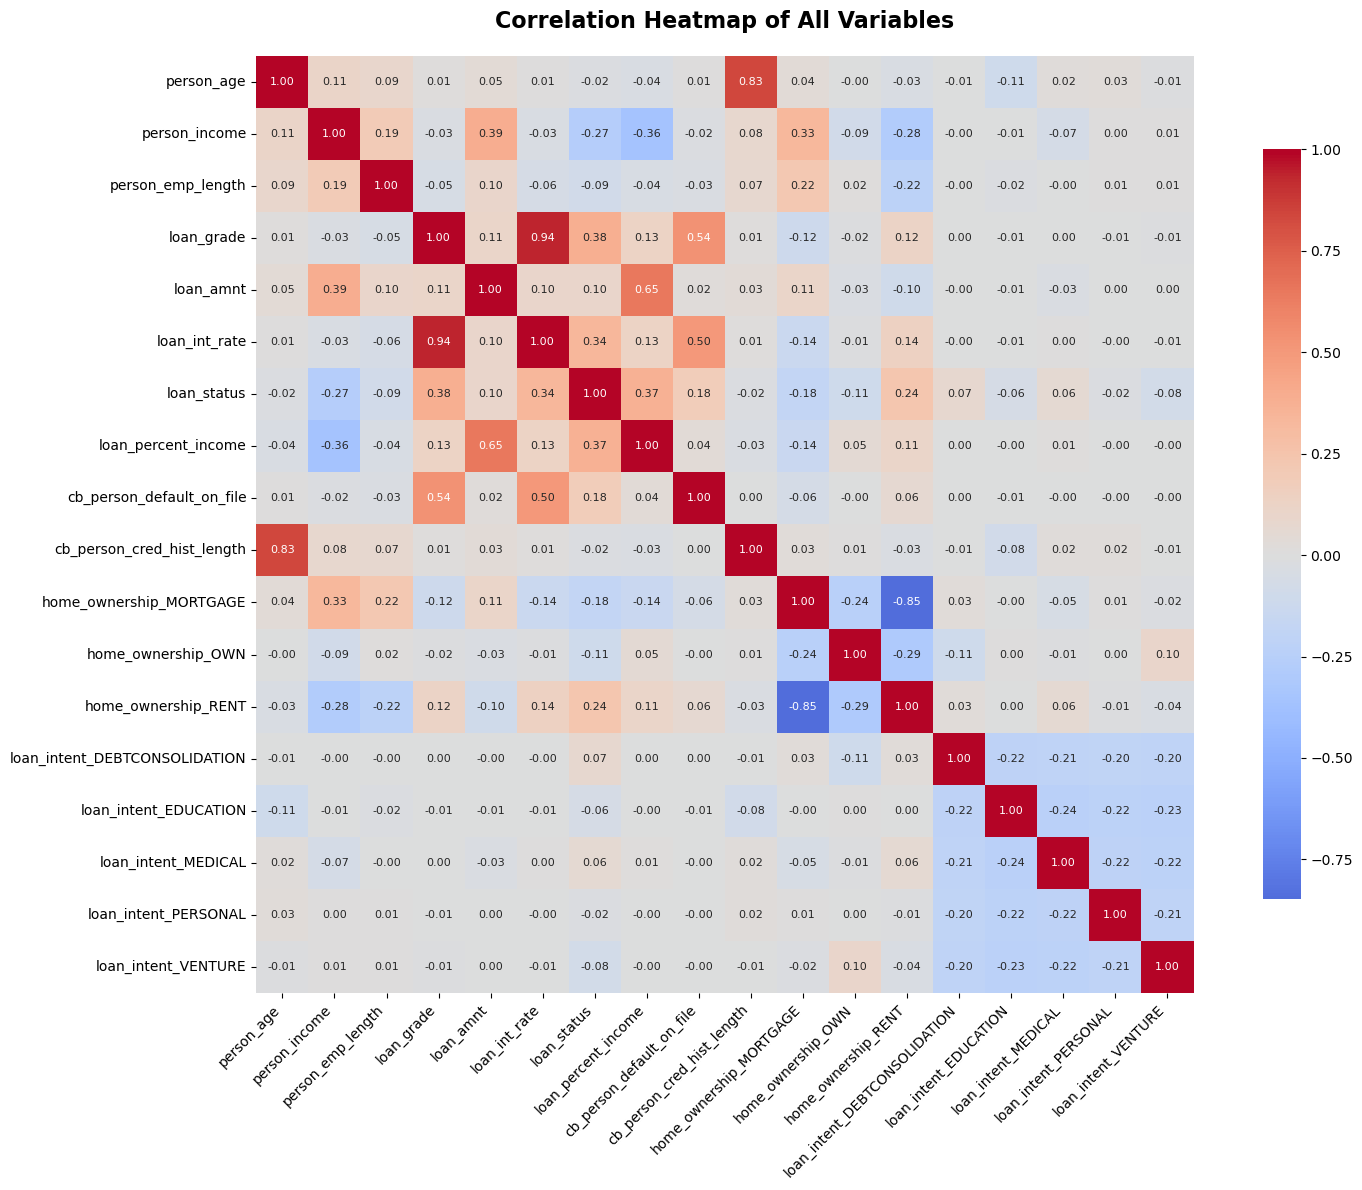

Strongest correlations with loan_status:
loan_status                  1.000000
loan_grade                   0.379393
loan_percent_income          0.365163
loan_int_rate                0.340210
person_income                0.266340
home_ownership_RENT          0.236027
home_ownership_MORTGAGE      0.181073
cb_person_default_on_file    0.180987
home_ownership_OWN           0.110323
loan_amnt                    0.099841
Name: loan_status, dtype: float64


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = data.corr()

# Create the heatmap
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    square=True,
    fmt='.2f',
    cbar_kws={"shrink": 0.8},
    annot_kws={'size': 8}
)

plt.title('Correlation Heatmap of All Variables', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations with loan_status (target variable)
print("Strongest correlations with loan_status:")
loan_status_corr = correlation_matrix['loan_status'].abs().sort_values(ascending=False)
print(loan_status_corr.head(10))


Since we will be using tree-based models and deep learning, high linear correlation among features is not a major concern. Neural networks can capture non-linear relationships, and tree-based methods can inherently select the most relevant features.

# Final dataset

In [ ]:
#data.to_csv('data_models\\final_data.csv', index=False)

In [82]:
data= pd.read_csv('data_models\\final_data.csv')

# Splits

In [83]:
X = data.drop('loan_status', axis=1)
y=data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, shuffle=True, stratify=y)

# Models

## Assemble

### normal

In [38]:


# Define the individual models
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=300, 
    max_depth=5
)

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=22,
    verbosity=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.01,
    random_state=22,
    verbosity=0
)

# Create the ensemble with majority voting
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lgb', lgb_model),
        ('xgb', xgb_model)
    ],
    voting='hard'  # Use 'hard' for majority voting
)

# Cross-validation on ensemble
cv_results = cross_validate(
    ensemble_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

print("Ensemble Cross-validation F1 scores:", cv_results['test_score'])
print("Mean F1:", cv_results['test_score'].mean())
print("Std F1:", cv_results['test_score'].std())

Ensemble Cross-validation F1 scores: [0.79934747 0.80709296 0.79632631 0.79760609 0.80280929]
Mean F1: 0.8006364256365451
Std F1: 0.003894344786564273


In [39]:
# Fit ensemble on full training set
ensemble_model.fit(X_train, y_train)

# Predict on test set
ensemble_predictions = ensemble_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

ensemble_f1 = f1_score(y_test, ensemble_predictions)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)

print("Ensemble Test Results:")
print(f"F1 Score: {ensemble_f1:.4f}")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"Recall: {ensemble_recall:.4f}")
print(f"Precision: {ensemble_precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, ensemble_predictions))

Ensemble Test Results:
F1 Score: 0.8024
Accuracy: 0.9284
Recall: 0.6798
Precision: 0.9789

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5032
           1       0.98      0.68      0.80      1368

    accuracy                           0.93      6400
   macro avg       0.95      0.84      0.88      6400
weighted avg       0.93      0.93      0.92      6400


Confusion Matrix:
[[5012   20]
 [ 438  930]]


In [40]:
# Compare individual models with ensemble
models = {
    'Random Forest': rf_model,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'Ensemble': ensemble_model
}

results_comparison = {}

for name, model in models.items():
    if name != 'Ensemble':  # Individual models need to be fitted
        model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    
    results_comparison[name] = {
        'F1 Score': f1,
        'precision': precision,
        'recall': recall
    }

# Display results
import pandas as pd
results_df = pd.DataFrame(results_comparison).T
print("Model Comparison:")
print(results_df.round(4))

Model Comparison:
               F1 Score  precision  recall
Random Forest    0.7712     0.9659  0.6418
LightGBM         0.8240     0.9565  0.7237
XGBoost          0.8014     0.9820  0.6769
Ensemble         0.8024     0.9789  0.6798


In [50]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=3,
    verbosity=-1
)

# Cross-validation
cv_results = cross_validate(
    lgb_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

f1 = cv_results['test_score']
print("Cross-validation f1:", f1)

Cross-validation f1: [0.82027168 0.8248062  0.80609564 0.81536034 0.81615743]


In [51]:
# Predict on train and test
lgb_model.fit(X_train, y_train)
train_preds = lgb_model.predict(X_train)
test_preds = lgb_model.predict(X_test)

# Evaluate
train_score = f1_score(y_train, train_preds)
test_score = f1_score(y_test, test_preds)

print(f"Train f1: {train_score:.4f}")
print(f"Test f1: {test_score:.4f}")

Train f1: 0.8666
Test f1: 0.8240


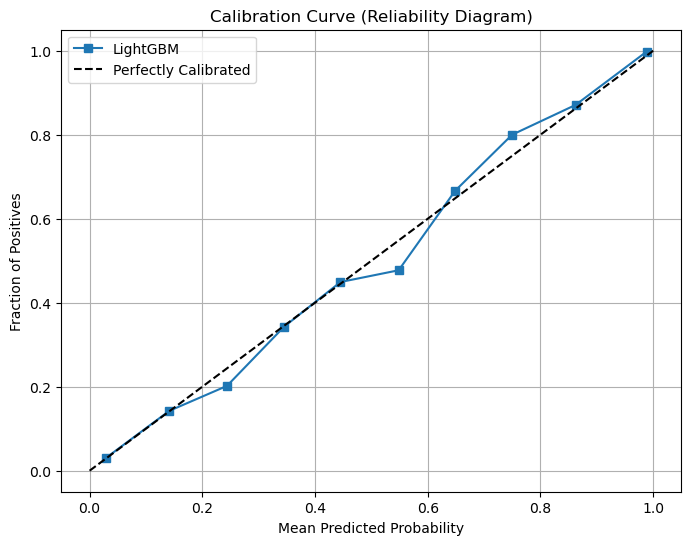

In [52]:
pred_probs_lgb = lgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for class 1 (default)

# Calculate calibration curve for LightGBM
fraction_of_positives_lgb, mean_predicted_value_lgb = calibration_curve(
    y_test, pred_probs_lgb, n_bins=10
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_lgb, fraction_of_positives_lgb, "s-", label="LightGBM")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")  # Diagonal line

plt.title("Calibration Curve (Reliability Diagram)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()



In [53]:
import joblib
joblib.dump(lgb_model, 'data_models\\best_tree_model.pkl')

['data_models\\best_tree_model.pkl']

### With data augmentation

In [122]:
import pandas as pd
import dice_ml
from dice_ml import Dice
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## NN

In [84]:
X = X.values 
y = y.values 

In [59]:
# Define per-fold score containers
pre_per_fold = []
recall_per_fold = []
loss_per_fold = []
history_per_fold = []

# Best model tracking
best_model = None
best_score = 1000
best_fold = 0

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
  scaler = RobustScaler()
  X_training = scaler.fit_transform(X[train])
  X_test = scaler.transform(X[test])
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)
  # Define the model architecture
  model = None
  model= Sequential()
  model.add(Dense(128,activation="relu",  kernel_regularizer=l2(0.001)))
  model.add(Dense(64,activation="relu", kernel_regularizer=l2(0.001)))
  model.add(Dense(32,activation="relu",  kernel_regularizer=l2(0.001)))
  model.add(Dense(16,activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['precision', 'recall'])


  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model and store the losses per fold during training
  history = model.fit(X_training, y[train], validation_data =[X_test, y[test]],
              batch_size=8,
              epochs=20,
              verbose=1,
              callbacks=[early_stopping])
  history_per_fold.append(history.history['loss'])

  # Generate generalization metrics and evaluate on the k-1 fold
  scores = model.evaluate(X_test, y[test], verbose=1)
  print(f'Score for fold {fold_no}: Loss: {scores[0]:.4f} - precision: {scores[1]:.4f} - Recall: {scores[2]:.4f}')
  
  recall_per_fold.append(scores[2])
  pre_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1

print(f'\nBest model from fold {best_fold} with loss: {best_score:.4f}')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.4373 - precision: 0.7435 - recall: 0.4972 - val_loss: 0.3023 - val_precision: 0.9105 - val_recall: 0.6096
Epoch 2/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3073 - precision: 0.8798 - recall: 0.6369 - val_loss: 0.2924 - val_precision: 0.9461 - val_recall: 0.6031
Epoch 3/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2976 - precision: 0.8929 - recall: 0.6434 - val_loss: 0.2864 - val_precision: 0.9286 - val_recall: 0.6184
Epoch 4/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2982 - precision: 0.8927 - recall: 0.6505 - val_loss: 0.2822 - val_precision: 0.9304 - val_recall: 0.6447
Epoch 5/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3003 - precision: 0.8904 - recall: 0.6514 - val_loss: 0.2801 - val_precision: 0.8763 - val_recall: 0.6988
Epoch 6/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

In [60]:
# Provide average scores
print('Score per fold')
for i in range(0, len(pre_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - precision: {pre_per_fold[i]:.4f} - Recall: {recall_per_fold[i]:.4f}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> precision: {np.mean(pre_per_fold):.4f} (+- {np.std(pre_per_fold):.4f})')
print(f'> Recall: {np.mean(recall_per_fold):.4f} (+- {np.std(recall_per_fold):.4f})')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.2831 - precision: 0.9190 - Recall: 0.6718
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2848 - precision: 0.9330 - Recall: 0.6411
------------------------------------------------------------------------
> Fold 3 - Loss: 0.3172 - precision: 0.8086 - Recall: 0.7140
------------------------------------------------------------------------
> Fold 4 - Loss: 0.2904 - precision: 0.9589 - Recall: 0.6138
------------------------------------------------------------------------
> Fold 5 - Loss: 0.3256 - precision: 0.8096 - Recall: 0.7154
------------------------------------------------------------------------
Average scores for all folds:
> precision: 0.8858 (+- 0.0639)
> Recall: 0.6712 (+- 0.0400)
> Loss: 0.3002
------------------------------------------------------------------------


In [85]:
# Scale the test data using the same scaler from training
scaler = RobustScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [86]:
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Define NN architecture
model = Sequential()
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['precision', 'recall']
)

# Train on full training set, validate on test set
history = model.fit(
    X_train_scaled, y_train,
    batch_size=8,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.4289 - precision: 0.7730 - recall: 0.5261
Epoch 2/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3141 - precision: 0.8710 - recall: 0.6306
Epoch 3/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2961 - precision: 0.8875 - recall: 0.6517
Epoch 4/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2953 - precision: 0.8944 - recall: 0.6474
Epoch 5/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2931 - precision: 0.8971 - recall: 0.6468
Epoch 6/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2913 - precision: 0.9025 - recall: 0.6572
Epoch 7/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2979 - precision: 0.9042 - recall: 0.6488
Epoch 8/20
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2955 - precision: 0.9014 - recall: 0.6483


In [89]:
# Predict classes on train set
train_preds = (model.predict(X_train_scaled) > 0.5).astype(int)
train_f1 = f1_score(y_train, train_preds)
print(f"Train F1 score: {train_f1:.4f}")

# Predict classes on test set
predictions = (model.predict(X_test_scaled) > 0.5).astype(int)
test_f1 = f1_score(y_test, predictions)
print(f"Test F1 score: {test_f1:.4f}")

800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step
Train F1 score: 0.7631
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
Test F1 score: 0.7571


Text(70.72222222222221, 0.5, 'Actual')

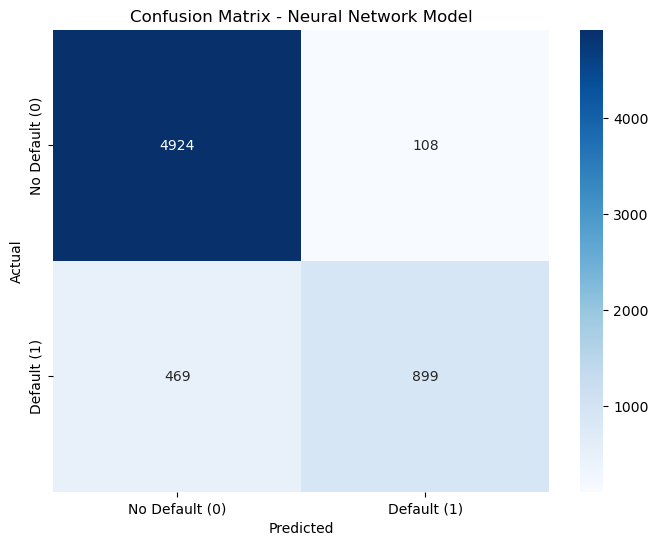

In [90]:
# Create confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix - Neural Network Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
# Save the best model
#model.save('best_nn_model.keras')

In [92]:
best_model = keras.models.load_model('best_nn_model.keras')

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


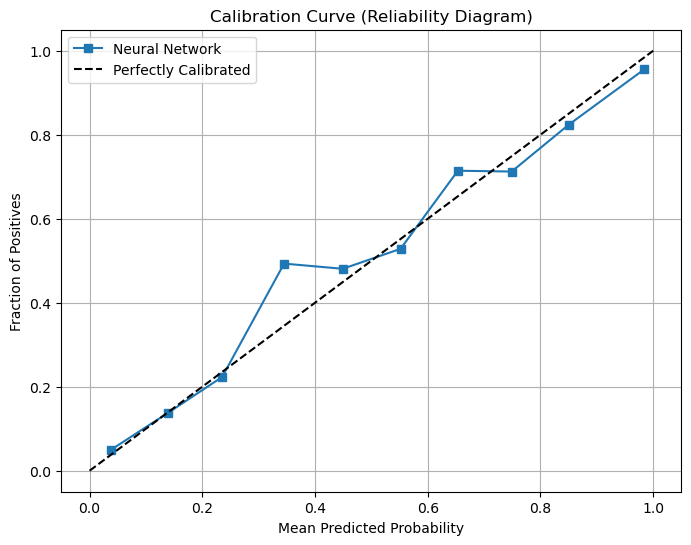

In [93]:
# Make sure we have the correct data format
pred_probs_nn = best_model.predict(X_test_scaled).flatten()

# Calculate calibration curve for Neural Network
fraction_of_positives_nn, mean_predicted_value_nn = calibration_curve(
    y_test, pred_probs_nn, n_bins=10
)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_nn, fraction_of_positives_nn, "s-", label="Neural Network")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")  # Diagonal line

plt.title("Calibration Curve (Reliability Diagram)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.show()

### Extras

#### Shap

In [94]:
import shap

In [95]:
# Create a function that returns probabilities (SHAP works better with probabilities)
def model_predict(X):
    return best_model.predict(X).flatten()

# Initialize SHAP explainer with a subset of training data as background
# Using 100 samples for faster computation
background_data = X_train_scaled[:100]
explainer = shap.DeepExplainer(best_model, background_data)

# Calculate SHAP values for a subset of test data (first 100 samples for speed)
test_sample = X_test_scaled[:100]
shap_values = explainer.shap_values(test_sample)
shap_values = shap_values[:, :, 0]
print(f"Shape of SHAP values: {shap_values.shape}")

c:\Users\david\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Shape of SHAP values: (100, 17)


In [96]:
feature_names = data.drop('loan_status', axis=1).columns.tolist()

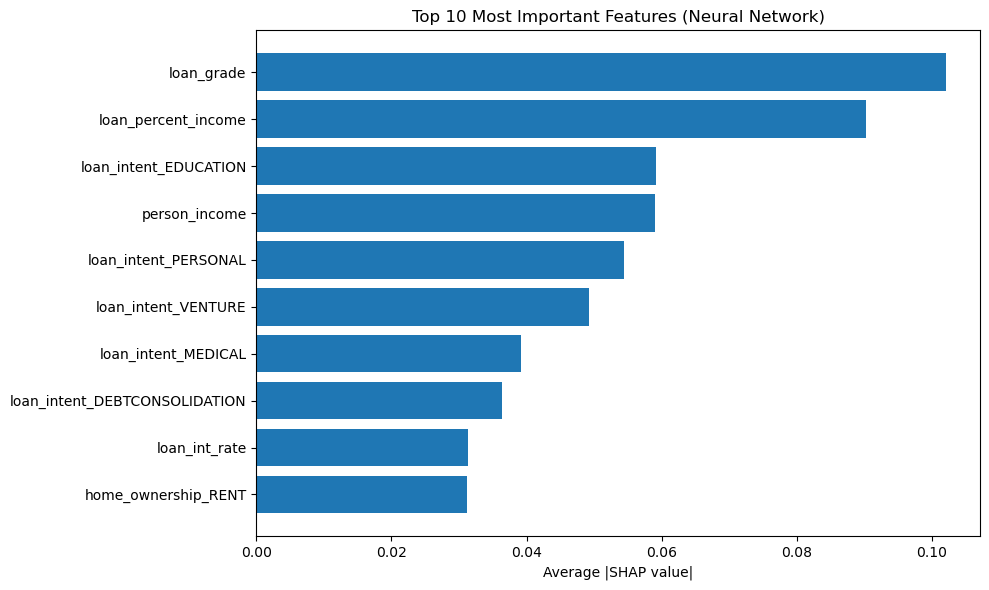

In [97]:
# 3. Feature importance ranking
feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)


# Plot top 10 features
plt.figure(figsize=(10, 6))
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Average |SHAP value|')
plt.title('Top 10 Most Important Features (Neural Network)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

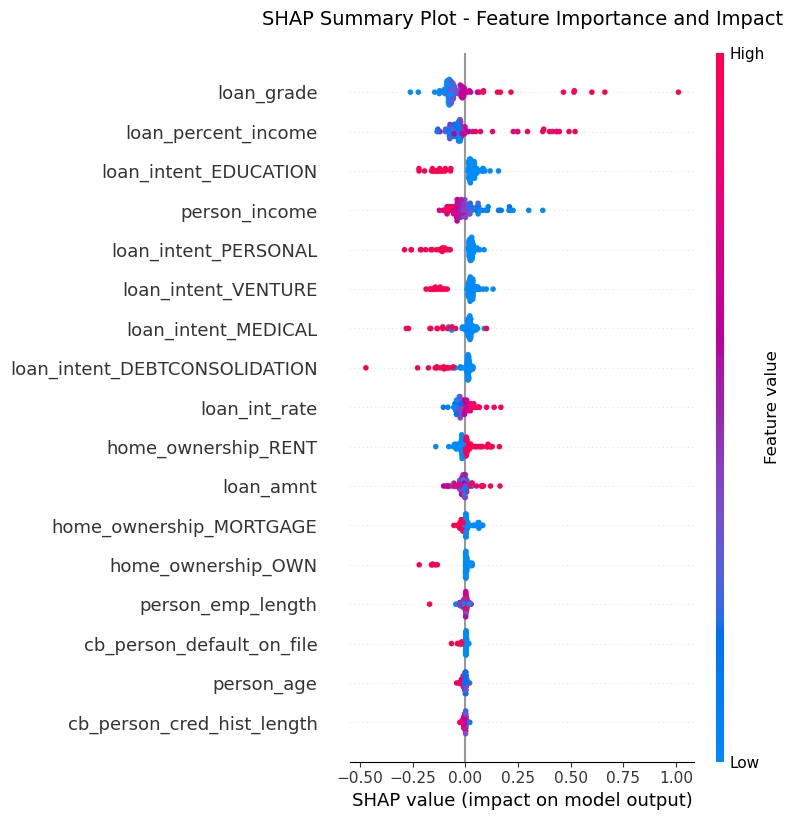

In [98]:
# 1. Summary plot - shows feature importance and impact
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, test_sample, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Feature Importance and Impact', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

A SHAP value close to zero means the feature had little impact on that prediction.

Positive SHAP values push the prediction higher (increase likelihood of the predicted outcome).

Negative SHAP values push the prediction lower (decrease likelihood of the predicted outcome).

#### Lime

In [99]:
import lime
import lime.lime_tabular

In [102]:
# Prepare data for LIME
# We need to use the original DataFrame format for LIME
data_temp = pd.read_csv('data_models\\final_data.csv')
X_lime = data_temp.drop('loan_status', axis=1)
y_lime = data_temp['loan_status']

# Split the data (same as before)
X_train_lime, X_test_lime, y_train_lime, y_test_lime = train_test_split(
    X_lime, y_lime, test_size=0.2, random_state=22, shuffle=True, stratify=y_lime
)

In [103]:
# Create a wrapper function for the neural network model
def nn_predict_proba(X):
    """
    Wrapper function to make predictions compatible with LIME
    """
    # Scale the input data
    scaler = RobustScaler()  
    X_scaled = scaler.fit_transform(X)
    
    # Get predictions
    probabilities = best_model.predict(X_scaled)
    
    # LIME expects probabilities for both classes
    # prob_class_0 = 1 - probabilities, prob_class_1 = probabilities
    prob_both_classes = np.column_stack([1 - probabilities.flatten(), probabilities.flatten()])
    
    return prob_both_classes


In [104]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_lime.values,  # Training data
    feature_names=X_train_lime.columns.tolist(),  # Feature names
    class_names=['No Default', 'Default'],  # Class names
    mode='classification',  # Classification mode
    discretize_continuous=True,  # Discretize continuous features
    random_state=42
)

print("LIME explainer initialized successfully!")

LIME explainer initialized successfully!


In [105]:
# Select interesting observations to explain
predictions_lime = nn_predict_proba(X_test_lime.values)
probabilities = predictions_lime[:, 1]  # Probability of default

# Select 4 random observations for LIME analysis
np.random.seed(11)  # For reproducibility
random_indices = np.random.choice(len(X_test_lime), 4, replace=False)

print("Selected random observations for LIME analysis:")
for i, idx in enumerate(random_indices):
    print(f"Observation {i+1} (idx {idx}): Probability of default = {probabilities[idx]:.4f}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
Selected random observations for LIME analysis:
Observation 1 (idx 4053): Probability of default = 0.1027
Observation 2 (idx 4820): Probability of default = 0.0721
Observation 3 (idx 1642): Probability of default = 0.0119
Observation 4 (idx 5619): Probability of default = 0.2101


LIME ANALYSIS - 4 RANDOM OBSERVATIONS

--------------------------------------------------
OBSERVATION 1 (Index: 4053)
Predicted Probability of Default: 0.1027
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


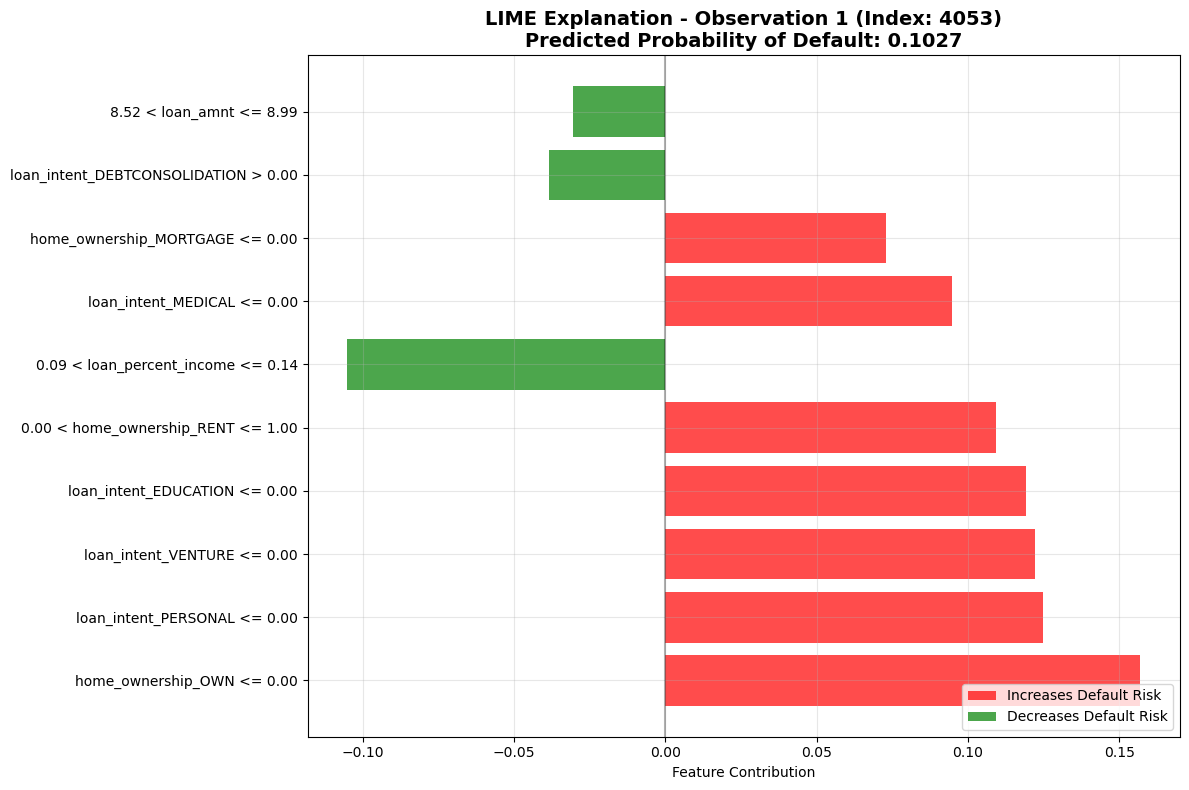


--------------------------------------------------
OBSERVATION 2 (Index: 4820)
Predicted Probability of Default: 0.0721
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


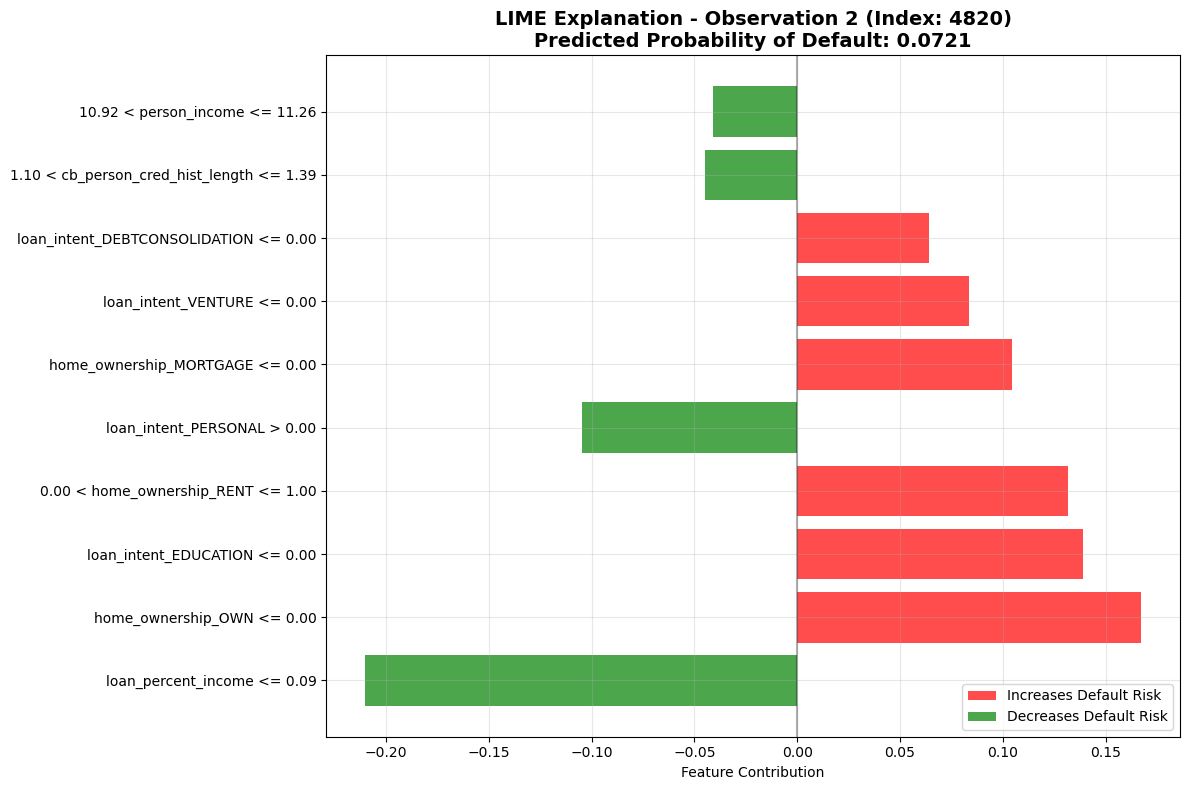


--------------------------------------------------
OBSERVATION 3 (Index: 1642)
Predicted Probability of Default: 0.0119
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


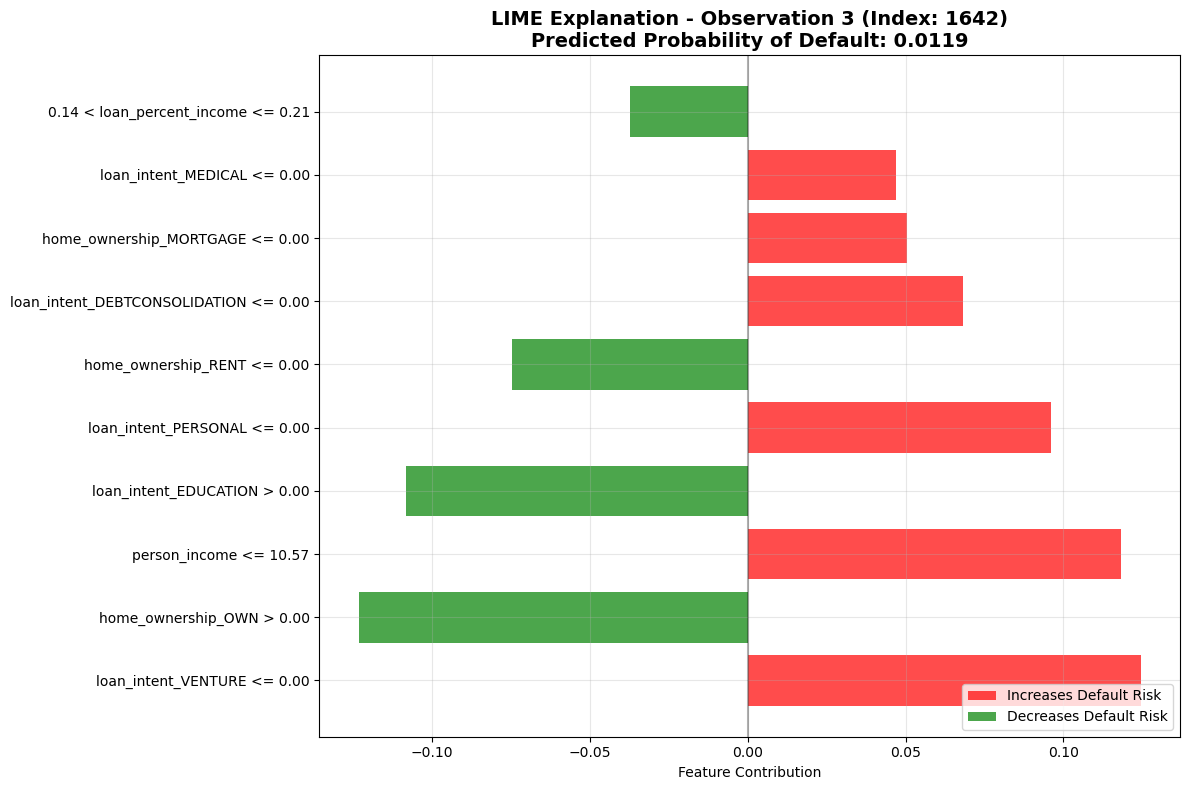


--------------------------------------------------
OBSERVATION 4 (Index: 5619)
Predicted Probability of Default: 0.2101
--------------------------------------------------
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


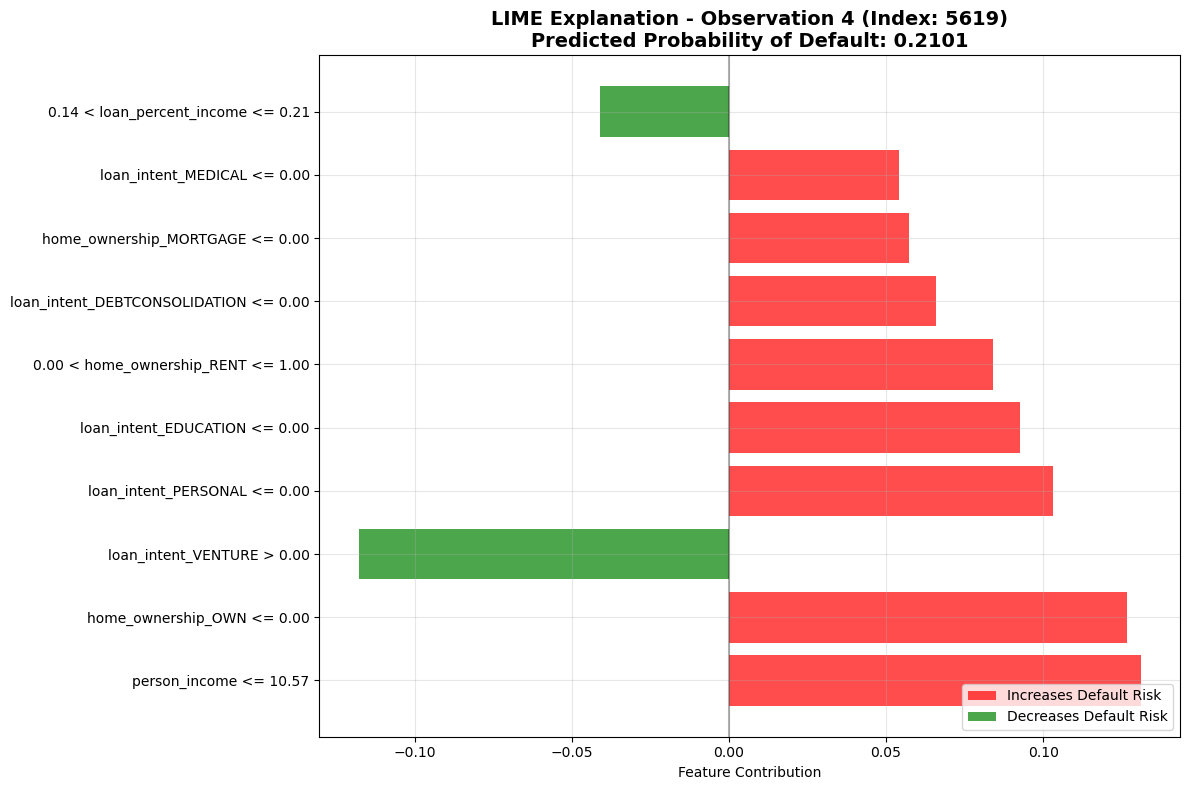

In [106]:
# LIME explanation for 4 random observations
print("="*80)
print("LIME ANALYSIS - 4 RANDOM OBSERVATIONS")
print("="*80)

explanations = []

for i, idx in enumerate(random_indices):
    print(f"\n{'-'*50}")
    print(f"OBSERVATION {i+1} (Index: {idx})")
    print(f"Predicted Probability of Default: {probabilities[idx]:.4f}")
    print(f"{'-'*50}")
    
    # Generate explanation
    explanation = explainer.explain_instance(
        X_test_lime.iloc[idx].values,  # Instance to explain
        nn_predict_proba,  # Prediction function
        num_features=10,  # Number of features to show
        num_samples=1000  # Number of samples for local approximation
    )
    
    explanations.append(explanation)
    
    # Create individual plot for this explanation
    plt.figure(figsize=(12, 8))
    
    # Get the explanation as matplotlib figure
    exp_list = explanation.as_list()
    features = [item[0] for item in exp_list]
    contributions = [item[1] for item in exp_list]
    
    # Create horizontal bar plot
    colors = ['red' if x > 0 else 'green' for x in contributions]
    y_pos = np.arange(len(features))
    
    plt.barh(y_pos, contributions, color=colors, alpha=0.7)
    plt.yticks(y_pos, features)
    plt.xlabel('Feature Contribution')
    plt.title(f'LIME Explanation - Observation {i+1} (Index: {idx})\nPredicted Probability of Default: {probabilities[idx]:.4f}', 
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Increases Default Risk'),
                      Patch(facecolor='green', alpha=0.7, label='Decreases Default Risk')]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()

In [107]:
# Detailed analysis table
print("\n" + "="*80)
print("DETAILED ANALYSIS SUMMARY")
print("="*80)

for i, (idx, explanation) in enumerate(zip(random_indices, explanations)):
    print(f"\nObservation {i+1} (Index: {idx})")
    print(f"Predicted Probability: {probabilities[idx]:.4f}")
    print(f"Prediction: {'DEFAULT' if probabilities[idx] > 0.5 else 'NO DEFAULT'}")
    print("-" * 50)
    
    print("Feature Contributions:")
    for j, (feature, contribution) in enumerate(explanation.as_list()[:8]):
        direction = "↑" if contribution > 0 else "↓"
        print(f"  {j+1:2d}. {feature:<35} {contribution:+7.4f} {direction}")


DETAILED ANALYSIS SUMMARY

Observation 1 (Index: 4053)
Predicted Probability: 0.1027
Prediction: NO DEFAULT
--------------------------------------------------
Feature Contributions:
   1. home_ownership_OWN <= 0.00          +0.1569 ↑
   2. loan_intent_PERSONAL <= 0.00        +0.1246 ↑
   3. loan_intent_VENTURE <= 0.00         +0.1221 ↑
   4. loan_intent_EDUCATION <= 0.00       +0.1190 ↑
   5. 0.00 < home_ownership_RENT <= 1.00  +0.1094 ↑
   6. 0.09 < loan_percent_income <= 0.14  -0.1051 ↓
   7. loan_intent_MEDICAL <= 0.00         +0.0948 ↑
   8. home_ownership_MORTGAGE <= 0.00     +0.0727 ↑

Observation 2 (Index: 4820)
Predicted Probability: 0.0721
Prediction: NO DEFAULT
--------------------------------------------------
Feature Contributions:
   1. loan_percent_income <= 0.09         -0.2101 ↓
   2. home_ownership_OWN <= 0.00          +0.1672 ↑
   3. loan_intent_EDUCATION <= 0.00       +0.1392 ↑
   4. 0.00 < home_ownership_RENT <= 1.00  +0.1315 ↑
   5. loan_intent_PERSONAL > 0.00    

## Best model

In [108]:
best_tree_model = joblib.load('data_models\\best_tree_model.pkl')

In [113]:
# Get predictions from the fitted LightGBM model
pred_probs_lgb = best_tree_model.predict_proba(X_test)[:, 1]

# Create a dataframe with predictions, true labels, and loan amounts
test_pred_df = pd.DataFrame({
    'prob_default': pred_probs_lgb,
    'true_loan_status': y_test,
    'loan_amnt': np.exp(X_test['loan_amnt'].values),  # Add loan amount for calculations
    'loan_int_rate': X_test['loan_int_rate'].values  # Add interest rate for calculations
})

test_pred_df['Total Expected Losses'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * 0.6

In [114]:
# Define acceptance rates to test
accept_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize lists to store results
thresholds = []
bad_rates = []
num_accepted = []
avg_loan_amt = []
total_expected_loss = []
avg_interest_rate = []

# Populate the arrays for the strategy table
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(test_pred_df['prob_default'], rate).round(3)
    thresholds.append(thresh)
    
    # Predict loan approval based on threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    
    # Get accepted loans (predicted to be non-default)
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    
    if len(accepted_loans) > 0:
        # Bad rate among accepted loans
        bad_rate = np.sum(accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])
        bad_rates.append(round(bad_rate, 3))

        # avg_int_rate
        avg_interest_rate.append(round(accepted_loans['loan_int_rate'].mean(), 2))  
        
        # Number of accepted loans
        num_accepted.append(len(accepted_loans))
        
        # Average loan amount
        avg_loan_amt.append(round(accepted_loans['loan_amnt'].mean(), 2))
        
        # Total expected loss
        total_exp_loss_accepted = accepted_loans['Total Expected Losses'].sum()
        total_expected_loss.append(round(total_exp_loss_accepted, 2))
    else:
        bad_rates.append(0.0)
        avg_interest_rate.append(0.0)  # This was the missing line that caused the error!
        num_accepted.append(0)
        avg_loan_amt.append(0.0)
        total_expected_loss.append(0.0)

# Create strategy DataFrame
strat_df = pd.DataFrame({
    'Acceptance Rate': accept_rates,
    'Threshold': thresholds,
    'Bad Rate': bad_rates,
    'Num Accepted': num_accepted,
    'Avg Loan Amt': avg_loan_amt,
    'Avg Interest Rate': avg_interest_rate,
    'Total Expected Loss': total_expected_loss
})

# Business metrics - format to avoid scientific notation
strat_df['Total Principal Lent Estimation'] = np.round(strat_df['Num Accepted'] * strat_df['Avg Loan Amt'], 2)
strat_df['Total Expected Revenue'] = np.round(strat_df['Total Principal Lent Estimation'] * strat_df['Avg Interest Rate'] / 100, 2)
strat_df['Net Expected Profit'] = np.round(strat_df['Total Expected Revenue'] - strat_df['Total Expected Loss'], 2)



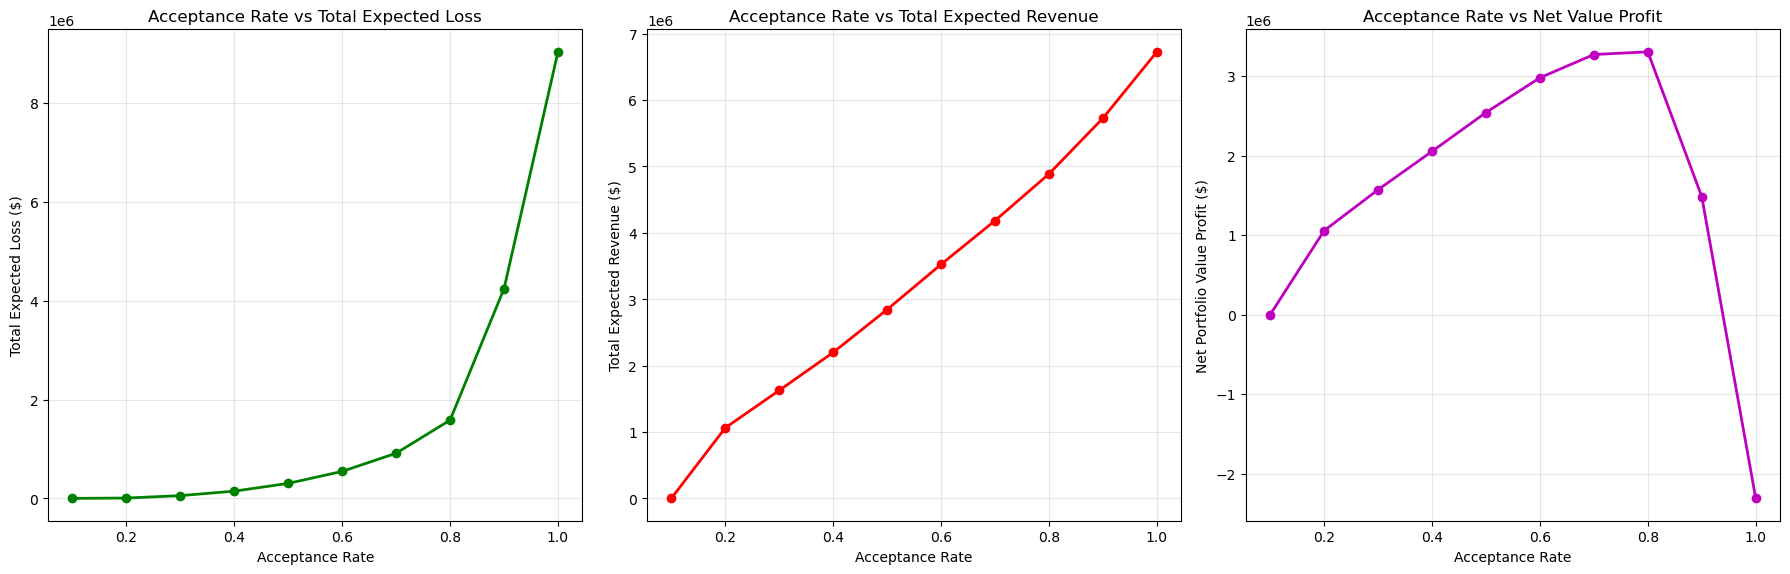

In [116]:
# Format the DataFrame to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot multiple metrics - 3 graphs only
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Acceptance Rate vs Total Expected Loss
ax1.plot(strat_df['Acceptance Rate'], strat_df['Total Expected Loss'], 'go-', linewidth=2, markersize=6)
ax1.set_xlabel('Acceptance Rate')
ax1.set_ylabel('Total Expected Loss ($)')
ax1.set_title('Acceptance Rate vs Total Expected Loss')
ax1.grid(True, alpha=0.3)

# Plot 2: Acceptance Rate vs Total Expected Revenue
ax2.plot(strat_df['Acceptance Rate'], strat_df['Total Expected Revenue'], 'ro-', linewidth=2, markersize=6)
ax2.set_xlabel('Acceptance Rate')
ax2.set_ylabel('Total Expected Revenue ($)')
ax2.set_title('Acceptance Rate vs Total Expected Revenue')
ax2.grid(True, alpha=0.3)

# Plot 3: Acceptance Rate vs Net Value
ax3.plot(strat_df['Acceptance Rate'], strat_df['Net Expected Profit'], 'mo-', linewidth=2, markersize=6)
ax3.set_xlabel('Acceptance Rate')
ax3.set_ylabel('Net Portfolio Value Profit ($)')
ax3.set_title('Acceptance Rate vs Net Value Profit')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal acceptance rate (highest net value)
optimal_idx = strat_df['Net Expected Profit'].idxmax()
optimal_rate = strat_df.loc[optimal_idx]

In [117]:
strat_df.head(10)
#Total Expected Loss=PD×EAD×LGD 
#Total Principal Lent Estimation = 'Num Accepted' * 'Avg Loan Amt'
#Total Expected Revenue = 'Total Principal Lent Estimation' * 'Avg Interest Rate' / 100
#Net Expected Profit = 'Total Expected Revenue' - 'Total Expected Loss'

,Acceptance Rate,Threshold,Bad Rate,Num Accepted,Avg Loan Amt,Avg Interest Rate,Total Expected Loss,Total Principal Lent Estimation,Total Expected Revenue,Net Expected Profit
0,0.10,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00
1,0.20,0.01,0.00,1265,9109.82,9.22,7054.84,11523922.30,1062505.64,1055450.80
2,0.30,0.02,0.01,1926,9373.51,9.01,56018.53,18053380.26,1626609.56,1570591.03
3,0.40,0.03,0.01,2539,9383.62,9.23,146356.39,23825011.18,2199048.53,2052692.14
4,0.50,0.05,0.02,3187,9376.73,9.52,303780.27,29883638.51,2844922.39,2541142.12
5,0.60,0.09,0.03,3842,9314.09,9.85,546566.87,35784733.78,3524796.28,2978229.41
6,0.70,0.14,0.04,4483,9213.50,10.13,913849.23,41304120.50,4184107.41,3270258.18
7,0.80,0.28,0.06,5120,9170.68,10.41,1583904.40,46953881.60,4887899.07,3303994.67
8,0.90,0.99,0.12,5753,9226.12,10.79,4244056.60,53077868.36,5727102.00,1483045.40
9,1.00,1.00,0.21,6400,9547.25,11.01,9038048.74,61102400.00,6727374.24,-2310674.50


Total Expected Loss=PD×EAD×LGD 

PD (Probability of Default)  

EAD (Exposure at Default)  The amount of money exposed to loss at the time of default. (money we gave and lost it) in this case loan amt


LGD (Loss Given Default)
The proportion of the EAD that is lost after accounting for recoveries (e.g., collateral).
Example: If 40% of the exposure is recovered, LGD = 0.6.

In [118]:
tot_exp_loss= round(test_pred_df['Total Expected Losses'].sum(),2)

Total expected loss:  $9,038,048.74

Expected Loss Statistics:
Mean expected loss per loan: $1412.20
Median expected loss per loan: $230.50
Max expected loss per loan: $20987.31
Total portfolio value: $61,102,425.00
Expected loss rate: 14.79%


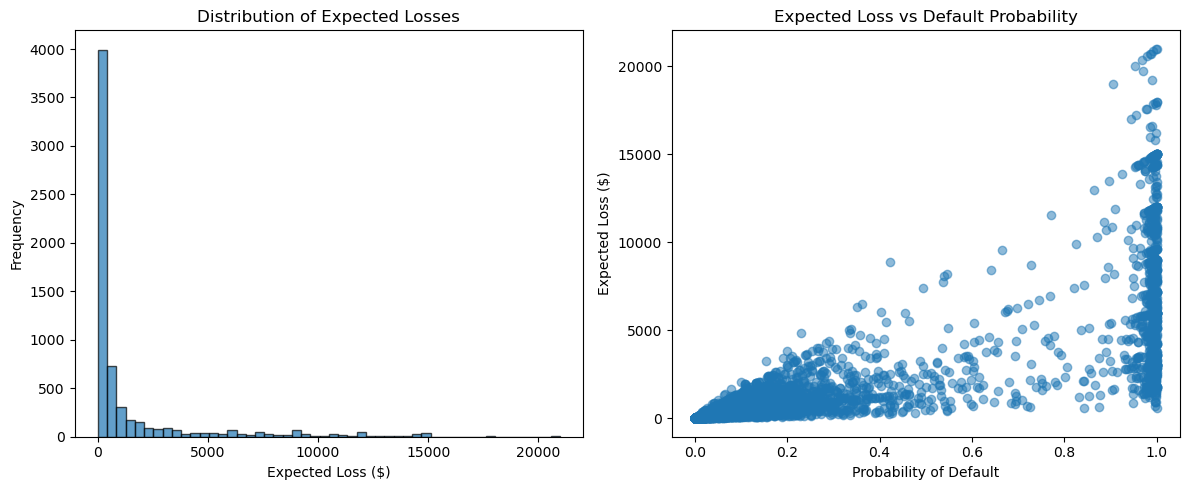

In [119]:
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

# Additional statistics
print(f"\nExpected Loss Statistics:")
print(f"Mean expected loss per loan: ${test_pred_df['Total Expected Losses'].mean():.2f}")
print(f"Median expected loss per loan: ${test_pred_df['Total Expected Losses'].median():.2f}")
print(f"Max expected loss per loan: ${test_pred_df['Total Expected Losses'].max():.2f}")
print(f"Total portfolio value: ${test_pred_df['loan_amnt'].sum():,.2f}")
print(f"Expected loss rate: {(tot_exp_loss / test_pred_df['loan_amnt'].sum()) * 100:.2f}%")

# Show distribution of expected losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_pred_df['Total Expected Losses'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Expected Loss ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Expected Losses')

plt.subplot(1, 2, 2)
plt.scatter(test_pred_df['prob_default'], test_pred_df['Total Expected Losses'], alpha=0.5)
plt.xlabel('Probability of Default')
plt.ylabel('Expected Loss ($)')
plt.title('Expected Loss vs Default Probability')

plt.tight_layout()
plt.show()